Step 1: Import necessary modules

In [2]:
# Standard libraries
import os
import sys

# Data manipulation
import pandas as pd
import numpy as np

# Visualization (optional for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing & pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

Step 2: Load the raw data

In [3]:
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Path to raw CSV
data_path = os.path.join(project_root, "data", "raw", "raw_data.csv")

# Load CSV
df = pd.read_csv(data_path)

# Quick look
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


Step 3: Aggregate features per customer

In [4]:
# Group by CustomerId and compute aggregates
agg_features = df.groupby('CustomerId').agg(
    total_transaction_amount=('Amount', 'sum'),
    average_transaction_amount=('Amount', 'mean'),
    transaction_count=('TransactionId', 'count'),
    std_transaction_amount=('Amount', 'std')
).reset_index()

# Fill NaN in standard deviation (single transaction customers)
agg_features['std_transaction_amount'] = agg_features['std_transaction_amount'].fillna(0)

# Preview
agg_features.head()

,CustomerId,total_transaction_amount,average_transaction_amount,transaction_count,std_transaction_amount
0,CustomerId_1,-10000.0,-10000.000000,1,0.000000
1,CustomerId_10,-10000.0,-10000.000000,1,0.000000
2,CustomerId_1001,20000.0,4000.000000,5,6558.963333
3,CustomerId_1002,4225.0,384.090909,11,560.498966
4,CustomerId_1003,20000.0,3333.333333,6,6030.478146


Check for any anomalies

In [5]:
# Summary statistics
agg_features.describe()

,total_transaction_amount,average_transaction_amount,transaction_count,std_transaction_amount
count,3.742000e+03,3.742000e+03,3742.000000,3.742000e+03
mean,1.717377e+05,1.571562e+04,25.564404,1.360517e+04
std,2.717305e+06,1.676991e+05,96.929602,9.689344e+04
min,-1.049000e+08,-4.250000e+05,1.000000,0.000000e+00
25%,4.077438e+03,1.000000e+03,2.000000,5.011411e+02
50%,2.000000e+04,2.583846e+03,7.000000,3.184898e+03
75%,7.996775e+04,4.877614e+03,20.000000,6.745369e+03
max,8.345124e+07,8.601821e+06,4091.000000,3.309916e+06


Save the aggregated features (optional)

In [6]:
agg_features.to_csv('../data/processed/agg_features.csv', index=False)

Step 4: Extract Temporal Features

In [7]:
# Make sure TransactionStartTime is datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract temporal features
df['transaction_hour'] = df['TransactionStartTime'].dt.hour
df['transaction_day'] = df['TransactionStartTime'].dt.day
df['transaction_month'] = df['TransactionStartTime'].dt.month
df['transaction_year'] = df['TransactionStartTime'].dt.year

# Preview the new features
df[['TransactionStartTime', 'transaction_hour', 'transaction_day', 'transaction_month', 'transaction_year']].head()


,TransactionStartTime,transaction_hour,transaction_day,transaction_month,transaction_year
0,2018-11-15 02:18:49+00:00,2,15,11,2018
1,2018-11-15 02:19:08+00:00,2,15,11,2018
2,2018-11-15 02:44:21+00:00,2,15,11,2018
3,2018-11-15 03:32:55+00:00,3,15,11,2018
4,2018-11-15 03:34:21+00:00,3,15,11,2018


: Combine Features

Objective: Merge the aggregate features (Step 1) with the temporal features (Step 2) for each customer.

In [8]:
# Merge aggregate features back to the main dataframe on CustomerId
df = df.merge(agg_features, on='CustomerId', how='left')

# Preview the combined dataframe
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,PricingStrategy,FraudResult,transaction_hour,transaction_day,transaction_month,transaction_year,total_transaction_amount,average_transaction_amount,transaction_count,std_transaction_amount
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,2,0,2,15,11,2018,109921.75,923.712185,119,3042.294251
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2,0,2,15,11,2018,109921.75,923.712185,119,3042.294251
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,2,0,2,15,11,2018,1000.00,500.000000,2,0.000000
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,2,0,3,15,11,2018,228727.20,6019.136842,38,17169.241610
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2,0,3,15,11,2018,228727.20,6019.136842,38,17169.241610


Step 5: Identify Categorical Columns and encoding

In [9]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']


In [10]:
from sklearn.preprocessing import LabelEncoder

# Columns for label encoding
label_cols = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId']

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Columns for one-hot encoding
df = pd.get_dummies(df, columns=['CurrencyCode', 'ProductCategory', 'ChannelId'], drop_first=True)

# Check the transformed dataframe
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,Amount,Value,...,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5
0,78150,46980,2490,3535,2584,256,5,1,1000.0,1000,...,False,False,False,False,False,False,False,False,True,False
1,75821,31755,3219,2366,2584,256,3,19,-20.0,20,...,True,False,False,False,False,False,False,True,False,False
2,39888,60272,2713,996,2806,256,5,0,500.0,500,...,False,False,False,False,False,False,False,False,True,False
3,48738,1797,3351,974,3733,256,0,11,20000.0,21800,...,False,False,False,False,False,False,True,False,True,False
4,41364,48941,3219,2366,3733,256,3,19,-644.0,644,...,True,False,False,False,False,False,False,True,False,False


Step 6: Handle Missing Values

In [11]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


Step 7: Normalize/Standardize Numerical Features

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Columns to scale
num_cols = [
    'Amount', 'Value', 'total_transaction_amount', 
    'average_transaction_amount', 'transaction_count', 
    'std_transaction_amount', 'transaction_hour', 
    'transaction_day', 'transaction_month', 'transaction_year'
]

# 1. Standardization
scaler_std = StandardScaler()
df[num_cols] = scaler_std.fit_transform(df[num_cols])

# 2. Optional: Normalization (MinMax scaling)
scaler_mm = MinMaxScaler()
df[num_cols] = scaler_mm.fit_transform(df[num_cols])

# Check the first 5 rows of scaled features
df[num_cols].head()

,Amount,Value,total_transaction_amount,average_transaction_amount,transaction_count,std_transaction_amount,transaction_hour,transaction_day,transaction_month,transaction_year
0,0.092004,0.000101,0.557522,0.047184,0.028851,0.000919,0.086957,0.466667,0.909091,0.0
1,0.091910,0.000002,0.557522,0.047184,0.028851,0.000919,0.086957,0.466667,0.909091,0.0
2,0.091958,0.000050,0.556944,0.047137,0.000244,0.000000,0.086957,0.466667,0.909091,0.0
3,0.093750,0.002206,0.558153,0.047749,0.009046,0.005187,0.130435,0.466667,0.909091,0.0
4,0.091853,0.000065,0.558153,0.047749,0.009046,0.005187,0.130435,0.466667,0.909091,0.0


In [13]:
#standardization
from sklearn.preprocessing import StandardScaler

num_cols = ['Amount', 'Value', 'total_transaction_amount', 'average_transaction_amount',
            'transaction_count', 'std_transaction_amount', 'transaction_hour',
            'transaction_day', 'transaction_month', 'transaction_year']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,Amount,Value,...,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5
0,78150,46980,2490,3535,2584,256,5,1,-0.046371,-0.072291,...,False,False,False,False,False,False,False,False,True,False
1,75821,31755,3219,2366,2584,256,3,19,-0.054643,-0.080251,...,True,False,False,False,False,False,False,True,False,False
2,39888,60272,2713,996,2806,256,5,0,-0.050426,-0.076352,...,False,False,False,False,False,False,False,False,True,False
3,48738,1797,3351,974,3733,256,0,11,0.107717,0.096648,...,False,False,False,False,False,False,True,False,True,False
4,41364,48941,3219,2366,3733,256,3,19,-0.059704,-0.075183,...,True,False,False,False,False,False,False,True,False,False


Step 7: Feature Engineering with WoE and IV

Standardize numerical features

In [17]:
# Check mean and std after scaling
df[num_cols].describe()

,Amount,Value,total_transaction_amount,average_transaction_amount,transaction_count,std_transaction_amount,transaction_hour,transaction_day,transaction_month,transaction_year
count,9.566200e+04,9.566200e+04,9.566200e+04,95662.000000,9.566200e+04,9.566200e+04,9.566200e+04,95662.000000,95662.000000,95662.000000
mean,-1.188422e-18,-1.188422e-18,-9.507377e-18,0.000000,4.753689e-18,9.507377e-18,2.376844e-17,0.000000,0.000000,0.000000
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005,1.000005e+00,1.000005e+00,1.000005e+00,1.000005,1.000005,1.000005
min,-8.164376e+00,-8.039691e-02,-4.646278e+00,-5.038543,-4.461315e-01,-2.012087e-01,-2.568161e+00,-1.662755,-1.065454,-0.994246
25%,-5.488653e-02,-7.817959e-02,1.678282e-01,-0.063689,-4.108492e-01,-1.658117e-01,-9.176352e-01,-0.881747,-1.065454,-0.994246
50%,-4.637114e-02,-7.229109e-02,1.743188e-01,-0.051876,-3.414227e-01,-1.354114e-01,1.139436e-01,0.010834,0.848684,-0.994246
75%,-3.177332e-02,-3.980285e-02,1.975924e-01,-0.030781,-1.365574e-01,-8.505814e-02,9.392067e-01,0.903415,1.040098,1.005787
max,8.007129e+01,8.016556e+01,3.992660e+00,100.312729,4.208861e+00,3.699897e+01,2.177101e+00,1.684423,1.040098,1.005787


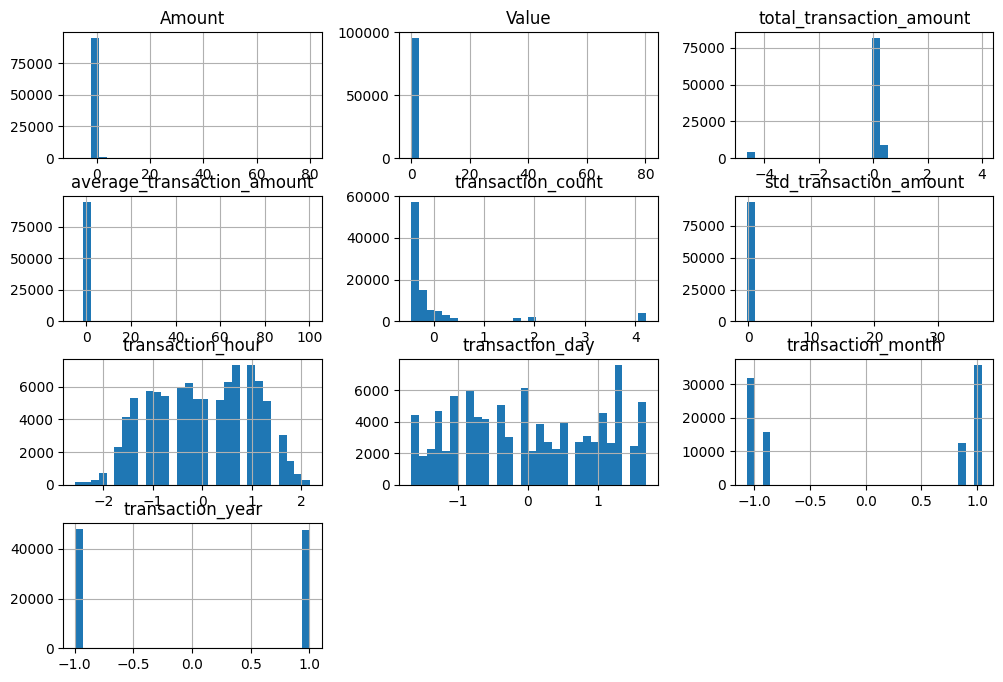

In [20]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Numeric columns to scale
num_cols = ['Amount', 'Value', 'total_transaction_amount', 'average_transaction_amount',
            'transaction_count', 'std_transaction_amount', 'transaction_hour',
            'transaction_day', 'transaction_month', 'transaction_year']

# Scale the numeric columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Plot distributions of the scaled columns
df[num_cols].hist(bins=30, figsize=(12,8))
plt.show()

In [37]:
import scorecardpy as sc
import pandas as pd

# Categorical columns to encode with WoE
cat_cols = ['CountryCode', 'ProviderId', 'ProductId']  # only existing categorical columns

# Numeric columns to bin and encode with WoE
num_cols = [
    'Amount', 'Value', 'total_transaction_amount', 'average_transaction_amount',
    'transaction_count', 'std_transaction_amount', 'transaction_hour',
    'transaction_day', 'transaction_month', 'transaction_year'
]

In [38]:
# Define the target
target = 'FraudResult'

# Generate WoE bins for categorical and numeric columns
bins = sc.woebin(df, y=target, x=cat_cols + num_cols)

# Transform the dataframe using the WoE bins
df_woe = sc.woebin_ply(df, bins)

# Check the transformed data
df_woe.head()

[INFO] creating woe binning ...


D:\Personal\KAIM-10 Academy\Week 4\Project\Credit-Risk-Modeling-Week 4\venv\Lib\site-packages\scorecardpy\condition_fun.py:34: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: CountryCode)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
D:\Personal\KAIM-10 Academy\Week 4\Project\Credit-Risk-Modeling-Week 4\venv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
D:\Personal\KAIM-10 Academy\Week 4\Project\Credit-Risk-Modeling-Week 4\venv\Lib\site-packages\scorecardpy\conditi

Binning on 95662 rows and 13 columns in 00:00:12
[INFO] converting into woe values ...


,BatchId,PricingStrategy,FraudResult,AccountId,ProductCategory_data_bundles,ProductCategory_transport,ProductCategory_tv,CountryCode,ChannelId_ChannelId_3,CustomerId,...,transaction_year_woe,transaction_count_woe,Amount_woe,ProviderId_woe,ProductId_woe,transaction_month_woe,std_transaction_amount_woe,transaction_day_woe,total_transaction_amount_woe,average_transaction_amount_woe
0,46980,2,0,2490,False,False,False,256,True,2584,...,-0.245002,0.148771,-4.430955,-3.137005,-1.817006,-0.587194,-1.967705,-0.592431,-3.891521,-3.071208
1,31755,2,0,3219,False,False,False,256,False,2584,...,-0.245002,0.148771,-4.430955,-2.736867,-2.812009,-0.587194,-1.967705,-0.592431,-3.891521,-3.071208
2,60272,2,0,2713,False,False,False,256,True,2806,...,-0.245002,0.996078,-4.430955,-3.137005,-1.817006,-0.587194,-1.967705,-0.592431,-2.862343,-3.071208
3,1797,2,0,3351,False,False,False,256,True,3733,...,-0.245002,0.148771,1.034203,1.937353,1.562838,-0.587194,-4.705167,-0.592431,-3.891521,-3.420700
4,48941,2,0,3219,False,False,False,256,False,3733,...,-0.245002,0.148771,-2.140258,-2.736867,-2.812009,-0.587194,-4.705167,-0.592431,-3.891521,-3.420700


In [40]:
import pandas as pd

# 'bins' is the output from sc.woebin()
iv_summary = []

for var, bin_df in bins.items():
    total_iv = bin_df['total_iv'].iloc[0]  # all rows in the bin have same total_iv
    iv_summary.append({'variable': var, 'total_iv': total_iv})

iv_summary = pd.DataFrame(iv_summary).sort_values(by='total_iv', ascending=False)
iv_summary

,variable,total_iv
8,std_transaction_amount,5.789245
11,average_transaction_amount,5.116476
10,total_transaction_amount,3.736760
5,ProviderId,3.278587
4,Amount,2.967562
0,Value,2.611838
6,ProductId,2.565330
2,transaction_count,0.673549
9,transaction_day,0.336958
1,transaction_hour,0.239027
